<a href="https://colab.research.google.com/github/teticio/aventuras-en-texto/blob/master/Atenci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attention = Atención

[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)

### Importar las librerías

In [0]:
import re
import os
import random
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, get_file
from keras.engine import Layer
from keras.layers import Input, LSTM, Dense, TimeDistributed
from keras.layers import Embedding, Concatenate, Dropout
from keras.models import Model
from keras import initializers
import keras.backend as K

### Conectar con Google Drive

In [3]:
checkpoint_dir = '.'

try: # estamos en Google Colab?
    from google.colab import drive
    drive.mount('/content/drive')
    checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/checkpoints'
except:
    pass

try: # crear directorio para los checkpoints (si no exista ya)
    os.makedirs(checkpoint_dir)
except FileExistsError:
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Descargar frases paralelas

In [0]:
#https://www.manythings.org/anki/spa-eng.zip
path_to_zip = get_file('spa-eng.zip',
                       origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
                       extract=True)
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [0]:
native = []
foreign = []
with open(path_to_file, 'rt') as file:
    for line in file.readlines():
        tab = line.find('\t')
        native += [line[:tab]]
        foreign += [line[tab+1:-1]]

In [492]:
native[123], foreign[123]

('Help me!', 'Ayúdame.')

In [0]:
foreign = ['[SOS] ' + _ + ' [EOS]' for _ in foreign]

### Añadir los tokens que marcan el comienzo ("[SOS]") y el final ("[EOS]") de cada frase

In [494]:
native[123], foreign[123]

('Help me!', '[SOS] Ayúdame. [EOS]')

### Tokenizar

In [0]:
max_words = 100000 #@param {type : 'number'}

native_tokenizer = Tokenizer(num_words = max_words, oov_token='[UNK]')
native_tokenizer.fit_on_texts(native)
native_index2word = dict(zip(native_tokenizer.word_index.values(), native_tokenizer.word_index.keys()))
native = native_tokenizer.texts_to_sequences(native)
native_vocab_size = min(max_words, len(native_tokenizer.index_word.keys()) + 1) # pad = 0

foreign_tokenizer = Tokenizer(num_words = max_words, oov_token='[UNK]')
foreign_tokenizer.fit_on_texts(foreign)
foreign_index2word = dict(zip(foreign_tokenizer.word_index.values(), foreign_tokenizer.word_index.keys()))
foreign = foreign_tokenizer.texts_to_sequences(foreign)
foreign_vocab_size = min(max_words, len(foreign_tokenizer.index_word.keys()) + 1) # pad = 0

In [496]:
native_vocab_size, foreign_vocab_size

(13526, 26937)

In [497]:
native[123], foreign[123]

([87, 18], [2, 2340, 3])

In [498]:
[native_index2word.get(_, "") for _ in native[123]], [foreign_index2word.get(_, "") for _ in foreign[123]]

(['help', 'me'], ['sos', 'ayúdame', 'eos'])

### Hacer que las secuencias tienen el mismo tamaño

In [0]:
max_len = 20 #@param {type : 'number'}

native = sequence.pad_sequences(native, maxlen=max_len, padding='pre', truncating='post')
foreign = sequence.pad_sequences(foreign, maxlen=max_len, padding='post', truncating='post') # OJO

In [500]:
native[123], foreign[123]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 87, 18], dtype=int32),
 array([   2, 2340,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

### Seq2Seq para NMT (*Neural Machine Translation*)

![texto alternativo](https://miro.medium.com/max/1000/1*7Ki7jDc2f_fH1mHluoZKpA.jpeg)
https://towardsdatascience.com/word-level-english-to-marathi-neural-machine-translation-using-seq2seq-encoder-decoder-lstm-model-1a913f2dc4a7

### Capa de Keras para convertir los tokens a vectores one hot

In [0]:
class OneHot(Layer):
    def __init__(self, number_of_tokens, **kwargs):
        super(OneHot, self).__init__(**kwargs)
        self.number_of_tokens = number_of_tokens

    def call(self, inputs):
        if K.dtype(inputs) != 'int32':
            inputs = K.cast(inputs, 'int32')
        return K.one_hot(inputs, self.number_of_tokens)
    
    def compute_output_shape(self, input_shape):
        return input_shape + (self.number_of_tokens,)

### Generador para pasar los token objetivos a vectores one hot

In [0]:
def batch_generator(x, y, num_tokens, batch_size = 128):
    indices = np.random.permutation(len(y))
    i = 0
    while True:
        start = i * batch_size
        end = start + batch_size
        batch = indices[start:end]
        batch_X = [x[0][batch], x[1][batch]]
        batch_Y = to_categorical(y[batch], num_tokens)
        i = i + 1
        if end >= len(y):
            i = 0
        yield(batch_X, batch_Y)

### Crear el modelo: el *encoder*

In [0]:
num_hidden_units = 1024 #@param {type : 'number'}
embedding_dim = 256 #@param {type : 'number'}

encoder_inputs = Input(shape=(max_len,), name='encoder_inputs')
#encoder_embedding = OneHot(native_vocab_size)
encoder_embedding = Embedding(native_vocab_size, embedding_dim, name='encoder_embedding')
encoder_in = encoder_embedding(encoder_inputs)
encoder_lstm = LSTM(num_hidden_units, return_state=True, return_sequences=True, name='encoder_lstm')
encoder_out, state_h, state_c = encoder_lstm(encoder_in) # utilizaremos los output en otro modelo más adelante
encoder_states = [state_h, state_c]

### el *decoder*

In [0]:
decoder_inputs = Input(shape=(max_len - 1,), name='decoder_inputs') # OJO: secuencia con [SOS] pero sin [EOS]
#decoder_embedding = OneHot(foreign_vocab_size)
decoder_embedding = Embedding(foreign_vocab_size, embedding_dim, name='decoder_embedding')
decoder_in = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(num_hidden_units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_out, _, _ = decoder_lstm(decoder_in, initial_state=encoder_states)
decoder_dense = Dense(foreign_vocab_size, activation='softmax')
decoder_outputs = TimeDistributed(decoder_dense, name='decoder_dense')(decoder_out) # https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

### y el modelo completo

In [505]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
print('FULL MODEL')
model.summary()

FULL MODEL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, 19)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 20, 256)      3462656     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 19, 256)      6895872     decoder_inputs[0][0]             
__________________________________________________________________________________________________

### Entrenar el modelo

In [0]:
#model.load_weights(checkpoint_dir + '/Seq2SeqModel.h5')
batch_size = 512
model.fit_generator(batch_generator([native, foreign[:,:-1]], foreign[:, 1:], foreign_vocab_size, batch_size = batch_size),
                    steps_per_epoch=native.shape[0] // batch_size + 1,
                    epochs=100)

In [0]:
#model.save_weights(checkpoint_dir + '/Seq2SeqModel.h5')

In [0]:
model.load_weights(checkpoint_dir + '/Seq2SeqModel.h5')

### Visualizar los embedding

In [0]:
import pandas as pd
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

def plot_tsne(embedding_matrix, index_to_word, num_words = None, title = 't-SNE'):
    matrix = embedding_matrix
    if num_words is not None:
        matrix = matrix[:num_words,:]
    labels = [index_to_word.get(_, "<UNK>") for _ in range(matrix.shape[0])]
    
    # defining the chart
    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title=title,
                    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                    x_axis_type=None, y_axis_type=None, min_border=1)

    # dimensionality reduction. converting the vectors to 2d vectors
    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0)
    tsne_w2v = tsne_model.fit_transform(matrix)

    # putting everything in a dataframe
    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = labels

    # plotting. the corresponding word appears when you hover on the data point.
    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"": "@words"}
    show(fig)

In [0]:
plot_tsne(encoder_embedding.get_weights()[0], native_index2word, title='English')

Loading BokehJS ...

In [0]:
plot_tsne(decoder_embedding.get_weights()[0], foreign_index2word, title='Spanish')

Loading BokehJS ...

### *Teacher Forcing*



``model_inputs = [native, foreign[:,:-1]], model_outputs = foreign[:, 1:]
``



In [0]:
for i in range(10):
    ind = random.randint(0, len(native))
    sentence = (' ').join([native_index2word.get(_,'') for _ in native[ind]])
    target_sentence = (' ').join([foreign_index2word.get(_,'') for _ in foreign[ind][1:]])
    seq = np.expand_dims(native[ind], axis=0) 

    # empieza bien, pero rápidamente pierde el hilo
    dec_inputs = np.zeros((1, max_len - 1))
    dec_inputs[0, 0] = foreign_tokenizer.word_index['sos']
    dec_outputs = model.predict([seq, dec_inputs])
    tokens = np.argmax(dec_outputs, axis=-1)[0]
    translated_sentence = ' '.join([foreign_index2word.get(_,'') for _ in tokens])
    
    # esto va mejor, pero es hacer "trampa"...
    dec_inputs = np.expand_dims(foreign[ind,:-1], axis=0)
    dec_outputs = model.predict([seq, dec_inputs])
    tokens = np.argmax(dec_outputs, axis=-1)[0]
    translated_sentence_with_teacher_forcing = ' '.join([foreign_index2word.get(_,'') for _ in tokens])

    print(sentence)
    print(translated_sentence)
    print(translated_sentence_with_teacher_forcing)
    print(target_sentence)
    print()

                will the experiment succeed
nuestra                  
nuestra el experimento eos               
¿resultará el experimento eos               

               i can't explain it either
yo eso                 
yo tampoco puedo explicar eos              
yo tampoco puedo explicarlo eos              

               when did this custom start
¿cuándo última última                
¿cuándo se puso esta costumbre eos             
¿cuándo se inició esta costumbre eos             

                tom found the bug
tom a                 
tom encontró al el mundo eos             
tom dio con el bicho eos             

          we need a car big enough for the whole family
tenemos lo lo lo lo              
tenemos un niño suficiente suficientemente grande para mary la familia eos        
necesitamos un coche lo suficientemente grande para toda la familia eos        

              i asked him to make tea
le lo                 
le pedí que hiciera té eos             
le pedí que hi

![texto alternativo](https://miro.medium.com/max/700/1*xDPdW9nf7HdVDcBCQUJG7A.jpeg)

### Definir un encoder para hacer inferencia

In [443]:
encoder_inf_inputs = Input((max_len,), name='encoder_inf_inputs')
encoder_inf_in = encoder_embedding(encoder_inf_inputs)
encoder_inf_out, state_h, state_c = encoder_lstm(encoder_inf_in)
encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, state_h, state_c])
print('ENCODER')
encoder_model.summary()

ENCODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inf_inputs (InputLay (None, 20)                0         
_________________________________________________________________
encoder_embedding (Embedding (None, 20, 100)           20100     
_________________________________________________________________
encoder_lstm (LSTM)          [(None, 20, 64), (None, 6 42240     
Total params: 62,340
Trainable params: 62,340
Non-trainable params: 0
_________________________________________________________________


### y un decoder para hacer inferencia

In [0]:
decoder_init_states = [Input((num_hidden_units,), name='encoder_state_h'), Input((num_hidden_units,), name='encoder_state_c')]
encoder_inf_outputs = Input((max_len, num_hidden_units), name='encoder_inf_outputs')
decoder_inf_inputs = Input((1,), name='decoder_inf_inputs') # token por token
decoder_inf_in = decoder_embedding(decoder_inf_inputs)
decoder_inf_out, state_h, state_c = decoder_lstm(decoder_inf_in, initial_state=decoder_init_states)
decoder_inf_pred = TimeDistributed(decoder_dense, name='decoder_inf_dense')(decoder_inf_out)
decoder_model = Model(inputs=[encoder_inf_outputs] + decoder_init_states + [decoder_inf_inputs],
                      outputs=[decoder_inf_pred, state_h, state_c])
print('DECODER')
decoder_model.summary()

### *Greedy decoding*

In [240]:
frase_en_ingles = "Would you care for another cup of tea?" #@param {type : 'string'}
seq = native_tokenizer.texts_to_sequences([frase_en_ingles])
seq = sequence.pad_sequences(seq, maxlen=max_len, padding='pre', truncating='post')
sentence = (' ').join([native_index2word.get(_,'') for _ in seq[0]])
print(sentence)

            would you care for another cup of tea


In [241]:
enc_outputs, h, c = encoder_model.predict(seq)
dec_inputs = np.expand_dims(foreign_tokenizer.word_index['sos'], axis=0)
translated_sentence = ''
for i in range(max_len):
    dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])
    token = np.argmax(dec_outputs, axis=-1)[0, 0]
    word = foreign_index2word.get(token, '')
    if word == '' or word == 'eos':
        break
    dec_inputs = np.expand_dims(token, axis=0)
    translated_sentence += word + ' '
print(translated_sentence)

¿te importaría otro té esta la favor de la ciudad 


### *Beam Search* (beam = haz luminoso)

https://hackernoon.com/beam-search-a-search-strategy-5d92fb7817f

En lugar de simplemente elegir la palabra más probable en cada paso según $P[x_i]$, queremos elegir la frase más probable. Para ello, usamos la red para calcular las probabilidades de cada palabra condicionada en la previa $P[x_i|x_{i-1}]$. Queremos la frase $x_0 x_1 ... x_n$ con mayor probabilidad $P[x_0] P[x_1|x_0] ...  P[x_n|x_{n-1}]$.

El número de probabilidades que tenemos que calcular en cada paso expande como una "haz luminoso": de allí el nombre del algoritmo *beam search*. Limitamos la anchura de la haz en cada paso a las $k$ candidatos más probables.

En lugar de $P[x_0] P[x_1|x_0] ...  P[x_n|x_{n-1}]$ consideramos $\log P[x_0] + \log P[x_1|x_0] + ...  + \log P[x_n|x_{n-1}]$ para poder discriminar entre probabilidades muy pequeñas

In [97]:
k = 5
enc_outputs, h, c = encoder_model.predict(seq)
candidates = [('', 0, foreign_tokenizer.word_index['sos'])]
candidates # (frase_hasta_ahora, probabilidad de la última palabra condicionada en la previa, token de la última palabra)

[('', 0, 2)]

In [0]:
dec_inputs = np.array([[_[2]] for _ in candidates])
dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])

In [99]:
top_k = [np.flip(dec_outputs[token, 0].argsort()[-k:]) for token in range(min(k, len(candidates)))]
top_k # los siguientes token más probables

[array([ 161,  568,  318, 1699, 1369])]

In [100]:
next_candidates = [(candidates[token][0] + ' ' + foreign_index2word.get(top_k[token][next_token], ''), # frase hasta ahora
                    candidates[token][1] - np.log(dec_outputs[token, 0, top_k[token][next_token]]), # probabilidad de la última palabra condicionada en la previa
                    top_k[token][next_token]) # token de la última palabra
                   for next_token in range(k)
                   for token in range(len(top_k))]
candidates = sorted(next_candidates, key=lambda x:x[1])[:k]
candidates

[(' ¿te', 1.0201728343963623, 161),
 (' ¿le', 1.6088780164718628, 568),
 (' ¿quieres', 2.298142194747925, 318),
 (' ¿quiere', 2.8220221996307373, 1699),
 (' ¿os', 3.3055331707000732, 1369)]

In [101]:
# preparar batch para predicir las siguientes palabras condicionadas en estas
dec_inputs = np.array([[_[2]] for _ in candidates])
dec_inputs.shape, enc_outputs.shape, h.shape, c.shape

((5, 1), (1, 20, 64), (1, 64), (1, 64))

In [102]:
# igualar los tamaños de los inputs al modelo
h = np.repeat(h, dec_inputs.shape[0]-h.shape[0]+1, axis=0)
c = np.repeat(c, dec_inputs.shape[0]-c.shape[0]+1, axis=0)
enc_outputs = np.repeat(enc_outputs, dec_inputs.shape[0]-enc_outputs.shape[0]+1, axis=0)
dec_inputs.shape, enc_outputs.shape, h.shape, c.shape

((5, 1), (5, 20, 64), (5, 64), (5, 64))

In [103]:
# repetir para la siguiente palabra
dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])
top_k = [np.flip(dec_outputs[token, 0].argsort()[-k:]) for token in range(min(k, len(candidates)))]
next_candidates = [(candidates[token][0] + ' ' + foreign_index2word.get(top_k[token][next_token], ''), # frase hasta ahora
                    candidates[token][1] - np.log(dec_outputs[token, 0, top_k[token][next_token]]), # probabilidad de la última palabra condicionada en la previa
                    top_k[token][next_token]) # token de la última palabra
                   for next_token in range(k)
                   for token in range(len(top_k))]
sorted(next_candidates, key=lambda x:x[1])

[(' ¿te importaría', 1.3921476900577545, 1576),
 (' ¿le importaría', 1.814220204949379, 1576),
 (' ¿quieres otra', 3.438218593597412, 179),
 (' ¿te otro', 4.072036266326904, 211),
 (' ¿os otro', 4.379767298698425, 211),
 (' ¿quiere tomar', 4.38701069355011, 335),
 (' ¿quieres otro', 4.4617438316345215, 211),
 (' ¿quiere otra', 4.484291195869446, 179),
 (' ¿te importa', 4.631153583526611, 415),
 (' ¿quiere usted', 4.702415585517883, 129),
 (' ¿quieres tomar', 4.748530864715576, 335),
 (' ¿quiere otro', 5.1324217319488525, 211),
 (' ¿le importa', 5.2172781229019165, 415),
 (' ¿te gustaría', 5.222033262252808, 166),
 (' ¿os importaría', 5.236412405967712, 1576),
 (' ¿quieres muchas', 5.352567195892334, 267),
 (' ¿quieres más', 5.379870891571045, 32),
 (' ¿te costó', 5.504085302352905, 1367),
 (' ¿le gustaría', 5.7066954374313354, 166),
 (' ¿quiere más', 5.743963241577148, 32),
 (' ¿le das', 5.965032458305359, 1490),
 (' ¿le otro', 6.322639346122742, 211),
 (' ¿os otra', 6.707390308380127,

### Juntamos las piezas

In [104]:
k = 40 #@param {type : 'number'}
enc_outputs, h, c = encoder_model.predict(seq)
candidates = [('', 0, foreign_tokenizer.word_index['sos'])]
dec_inputs = np.array([[_[2]] for _ in candidates])
for i in range(max_len):
    h = np.repeat(h, dec_inputs.shape[0]-h.shape[0]+1, axis=0)
    c = np.repeat(c, dec_inputs.shape[0]-c.shape[0]+1, axis=0)
    enc_outputs = np.repeat(enc_outputs, dec_inputs.shape[0]-enc_outputs.shape[0]+1, axis=0)
    dec_outputs, h, c = decoder_model.predict([enc_outputs, h, c, dec_inputs])
    top_k = [np.flip(dec_outputs[token, 0].argsort()[-k:]) for token in range(min(k, len(candidates)))] 
    next_candidates = [(candidates[token][0] + ' ' + foreign_index2word.get(top_k[token][next_token], ''), # frase hasta ahora
                        candidates[token][1] - np.log(dec_outputs[token, 0, top_k[token][next_token]]), # probabilidad de la última palabra condicionada en la previa
                        top_k[token][next_token]) # token de la última palabra
                       for next_token in range(k)
                       for token in range(len(top_k))]
    candidates = sorted(next_candidates, key=lambda x:x[1])[:k]
    print(candidates[0][0])
#    if candidates[0][2] == 0 or candidates[0][2] == foreign_tokenizer.word_index['eos']:
#        break
    dec_inputs = np.array([[_[2]] for _ in candidates])

 ¿te
 ¿te importaría
 ¿te importaría otro
 ¿quieres otra taza de
 ¿te importaría otro encuentro de
 ¿quieres otra taza de té eos
 ¿quieres otra taza de té eos 
 ¿quieres otra taza de té eos  
 ¿quieres otra taza de té eos   
 ¿quieres otra taza de té eos    
 ¿quieres otra taza de té eos     
 ¿quieres otra taza de té eos      
 ¿quieres otra taza de té eos       
 ¿quieres otra taza de té eos        
 ¿quieres otra taza de té eos         
 ¿quieres otra taza de té eos          
 ¿quieres otra taza de té eos           
 ¿quieres otra taza de té eos            
 ¿quieres otra taza de té eos             
 ¿quieres otra taza de té eos              


In [105]:
for i, _ in enumerate(candidates):
    print(f'{i+1}.{_[0]}')

1. ¿quieres otra taza de té eos              
2. ¿quiere otra taza de la montaña eos             
3. ¿les importaría otra taza de lo que eos            
4. ¿quieres otra taza de la café eos             
5. ¿te importaría otro té ¿cuántas eos  a mí eos          
6. ¿le importaría otro diccionario sobre lo que quiero eos  a mí        
7. ¿te importaría otro encuentro de las mejores eos  esperar eos      hacerlo   
8. ¿te importaría otro hacer otra vez en otra vez  eos         
9. ¿te importaría otro diccionario naranjas en una opinión eos    eos       
10. ¿te importaría otro momento a la hora eos  a mí eos        
11. ¿te importaría otro negocio otra de  darte eos           
12. ¿te importaría otro país eos  lastimar eos            
13. ¿te importaría otro tamaño en una otra eos   esperar eos        
14. ¿te importaría otro hacer otra taza de cosas eos           
15. ¿te importaría otro modo en una tienda por años eos          
16. ¿te importaría otro trato eos  esperar eos            


### *Attention*

![texto alternativo](https://miro.medium.com/max/700/1*TkVKlV-Pk7POJUhlWHRgDA.png)

![texto alternativo](https://miro.medium.com/max/700/1*wcxAAgQ0n9gOXLRqhmaLGA.png)

https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39

![texto alternativo](https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg)
![texto alternativo](https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg)
https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention

*  Calculamos la atención con *scaled dot product* entre los vectores del encoder y el las variables latentes (*hidden state*) del decoder (del embedding o del LSTM, por ejemplo).
*  Podemos contectar el mecanismo de atención entre el embedding y el LSTM, o entre el LSTM y la capa dense. El primer enfoque requiere que pasemos los vectores de atención a cada LSTM en serie; el segundo enfoque es más fácil de implementar en Keras, y podemos pasar todos los vectores de atención a la capa dense en forma de matriz.

### Podemos usar un conjunto de datos con un vocabulario muy limitado para facilitar el entrenamiento...

In [0]:
path_en = get_file('small_vocab_en', origin='https://raw.githubusercontent.com/udacity/deep-learning/master/language-translation/data/small_vocab_en')
path_fr = get_file('small_vocab_fr', origin='https://raw.githubusercontent.com/udacity/deep-learning/master/language-translation/data/small_vocab_fr')

with open(path_en, 'rt') as file:
    native = [line[:-1] for line in file.readlines()]
with open(path_fr, 'rt') as file:
    foreign = [line[:-1] for line in file.readlines()]

foreign = ['[SOS] ' + _ + ' [EOS]' for _ in foreign]

native_tokenizer = Tokenizer(num_words = max_words, oov_token='[UNK]')
native_tokenizer.fit_on_texts(native)
native_index2word = dict(zip(native_tokenizer.word_index.values(), native_tokenizer.word_index.keys()))
native = native_tokenizer.texts_to_sequences(native)
native_vocab_size = min(max_words, len(native_tokenizer.index_word.keys()) + 1) # pad = 0

foreign_tokenizer = Tokenizer(num_words = max_words, oov_token='[UNK]')
foreign_tokenizer.fit_on_texts(foreign)
foreign_index2word = dict(zip(foreign_tokenizer.word_index.values(), foreign_tokenizer.word_index.keys()))
foreign = foreign_tokenizer.texts_to_sequences(foreign)
foreign_vocab_size = min(max_words, len(foreign_tokenizer.index_word.keys()) + 1) # pad = 0

native = sequence.pad_sequences(native, maxlen=max_len, padding='pre', truncating='post')
foreign = sequence.pad_sequences(foreign, maxlen=max_len, padding='post', truncating='post') # OJO

### Redefinimos el modelo para incluir una capa de atención

In [0]:
# adaptado de https://github.com/tensorflow/models/blob/master/official/transformer/model/attention_layer.py

class Attention(Layer):
    def __init__(self, hidden_size, attention_dropout=0, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.attention_dropout = attention_dropout
        # Layers for linearly projecting the queries, keys, and values.
        self.q_dense_layer = Dense(hidden_size, use_bias=False, name="q")
        self.k_dense_layer = Dense(hidden_size, use_bias=False, name="k")
        self.v_dense_layer = Dense(hidden_size, use_bias=False, name="v")
        self.output_dense_layer = Dense(hidden_size, use_bias=False,
                                        name="output_transform")
        
    def call(self, inputs, bias=0):
        """Apply attention mechanism to inputs.
        Args:
          inputs[0]: a tensor with shape [batch_size, length_encoder, hidden_size]
          inputs[1]: a tensor with shape [batch_size, length_decoder, hidden_size]
          bias: attention bias that will be added to the result of the dot product.
        Returns:
          Attention layer output with shape [batch_size, length_decoder, hidden_size]
          Attention weights with shape [batch_size, length_decoder, length_encoder]
        """
        q = self.q_dense_layer(inputs[1])
        k = self.k_dense_layer(inputs[0])
        v = self.v_dense_layer(inputs[0])

        # Scale q to prevent the dot product between q and k from growing too large.
        depth = self.hidden_size
        q *= depth ** -0.5

        # Calculate dot product attention
        logits =  K.batch_dot(q, K.permute_dimensions(k, [0, 2, 1]))
        logits += bias
        weights = K.softmax(logits)
        if self.attention_dropout > 0:
            weights = K.Dropout(weights, 1.0 - self.attention_dropout)
        attention_output = K.batch_dot(weights, v)
        
        # Run the combined outputs through another linear projection layer.
        attention_output = self.output_dense_layer(attention_output)
        return [attention_output, weights]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0][0], input_shape[1][1], self.hidden_size),
                (input_shape[1][0], input_shape[1][1], input_shape[0][1])]

### Conectamos las salidas del encoder y el decoder a una capa de atención...

In [0]:
attention_hidden_size = 1024 #@param {type : 'number'}

attn_layer = Attention(attention_hidden_size, name='attention')
attn_out, attn_weights = attn_layer([encoder_out, decoder_out])
decoder_cat = Concatenate()
decoder_merge = decoder_cat([decoder_out, attn_out])

### ...y las salidas de la capa de atención a la capa dense del decoder

In [0]:
decoder_dense = Dense(foreign_vocab_size, activation='softmax')
decoder_outputs = TimeDistributed(decoder_dense, name='decoder_dense')(decoder_merge)

### El modelo completo

In [510]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
print('FULL MODEL')
model.summary()

FULL MODEL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     (None, 19)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 20, 256)      3462656     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 19, 256)      6895872     decoder_inputs[0][0]             
__________________________________________________________________________________________________

In [0]:
#model.load_weights(checkpoint_dir + '/Seq2SeqAttnModel.h5')
batch_size = 512
model.fit_generator(batch_generator([native, foreign[:,:-1]], foreign[:, 1:], foreign_vocab_size, batch_size = batch_size),
                    steps_per_epoch=native.shape[0] // batch_size + 1,
                    epochs=100)

Epoch 1/100
233/233 [==============================] - 848s 4s/step - loss: 2.2815 - acc: 0.6802
Epoch 2/100
106/233 [============>.................] - ETA: 7:31 - loss: 1.7649 - acc: 0.7251

In [0]:
model.save_weights(checkpoint_dir + '/Seq2SeqAttnModel.h5')

In [0]:
model.load_weights(checkpoint_dir + '/Seq2SeqAttnModel.h5')

### Definimos un nuevo decoder con atención para hacer inferencia

In [477]:
decoder_init_states = [Input((num_hidden_units,), name='encoder_state_h'), Input((num_hidden_units,), name='encoder_state_c')]
encoder_inf_outputs = Input((max_len, num_hidden_units), name='encoder_inf_outputs')
decoder_inf_inputs = Input((1,), name='decoder_inf_inputs') # token por token
decoder_inf_in = decoder_embedding(decoder_inf_inputs)
decoder_inf_out, state_h, state_c = decoder_lstm(decoder_inf_in, initial_state=decoder_init_states)
attn_out, attn_weights = attn_layer([encoder_inf_outputs, decoder_inf_out])
decoder_inf_merge = decoder_cat([decoder_inf_out, attn_out])
decoder_inf_pred = TimeDistributed(decoder_dense, name='decoder_inf_dense')(decoder_inf_merge)
decoder_model = Model(inputs=[encoder_inf_outputs] + decoder_init_states + [decoder_inf_inputs],
                      outputs=[decoder_inf_pred, state_h, state_c, attn_weights])
print('DECODER')
decoder_model.summary()

DECODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inf_inputs (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   multiple             34800       decoder_inf_inputs[0][0]         
__________________________________________________________________________________________________
encoder_state_h (InputLayer)    (None, 64)           0                                            
__________________________________________________________________________________________________
encoder_state_c (InputLayer)    (None, 64)           0                                            
__________________________________________________________________________________________________
de

### Beam search con atención

In [478]:
frase_en_ingles = "Would you care for another cup of tea?" #@param {type : 'string'}
seq = native_tokenizer.texts_to_sequences([frase_en_ingles])
seq = sequence.pad_sequences(seq, maxlen=max_len, padding='pre', truncating='post')
sentence = (' ').join([native_index2word.get(_,'') for _ in seq[0]])
print(sentence)

k = 5 #@param {type : 'number'}
enc_outputs, h, c = encoder_model.predict(seq)
candidates = [('', 0, foreign_tokenizer.word_index['sos'], [])]
dec_inputs = np.array([[_[2]] for _ in candidates])
for i in range(max_len):
    h = np.repeat(h, dec_inputs.shape[0]-h.shape[0]+1, axis=0)
    c = np.repeat(c, dec_inputs.shape[0]-c.shape[0]+1, axis=0)
    enc_outputs = np.repeat(enc_outputs, dec_inputs.shape[0]-enc_outputs.shape[0]+1, axis=0)
    dec_outputs, h, c, attn = decoder_model.predict([enc_outputs, h, c, dec_inputs])
    top_k = [np.flip(dec_outputs[token, 0].argsort()[-k:]) for token in range(min(k, len(candidates)))] 
    next_candidates = [(candidates[token][0] + ' ' + foreign_index2word.get(top_k[token][next_token], ''), # frase hasta ahora
                        candidates[token][1] - np.log(dec_outputs[token, 0, top_k[token][next_token]]), # probabilidad de la última palabra condicionada en la previa
                        top_k[token][next_token], # token de la última palabra
                        candidates[token][3] + [attn[token]]) # vectores de atención
                       for next_token in range(k)
                       for token in range(len(top_k))]
    candidates = sorted(next_candidates, key=lambda x:x[1])[:k]
#    if candidates[0][2] == 0 or candidates[0][2] == foreign_tokenizer.word_index['eos']:
#        break
    dec_inputs = np.array([[_[2]] for _ in candidates])
attention_matrix = np.concatenate(candidates[0][3], axis=0)
for i, _ in enumerate(candidates):
    print(f'{i+1}.{_[0]}')

      the united states is sometimes chilly during december but is sometimes freezing in june
1. les états unis est parfois froid en décembre mais il est parfois le gel en juin eos   
2. les états unis est parfois froid en décembre mais il est parfois glaciales en janvier eos    
3. les états unis est parfois froid en décembre mais il est parfois beau en décembre eos    
4. les états unis est parfois froid en décembre mais il est parfois le gel en juillet eos   
5. les états unis est parfois frisquet en décembre mais il est parfois beau en décembre eos    


### Visualizar la matriz de atención

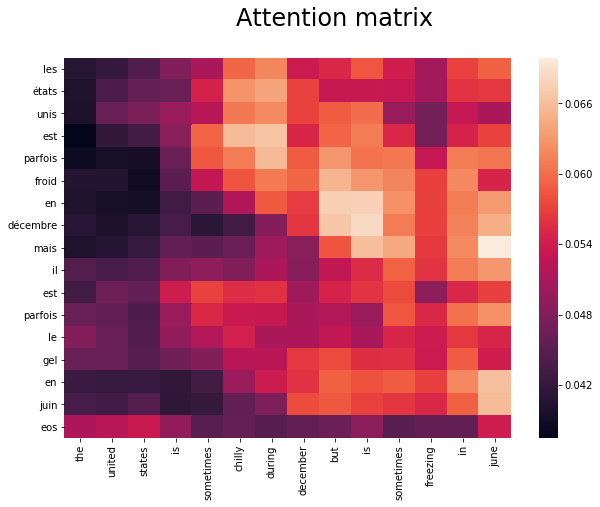

In [479]:
index = candidates[0][0].split()
columns = sentence.split()
df_cm = pd.DataFrame(attention_matrix[:len(index), -len(columns):], index=index, columns=columns)
fig = plt.figure(figsize=(10,7))
fig.suptitle('Attention matrix', fontsize=24)
sn.heatmap(df_cm)

In [0]:
# try with smaller data set
# call inference model with whole sentence and step by step to check attention matrix is the same

https://github.com/tensorflow/models/tree/master/official/transformer
https://github.com/tensorflow/models/blob/master/official/transformer/model/attention_layer.py